In [476]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from collections import Counter


In [477]:
data=pd.read_csv('data.csv' , encoding='latin1')
pd.set_option('display.max_columns', None)
data = data.rename(columns={'Étage': 'Etage'})
data = data.rename(columns={'Âge du bien' : 'Age de bien'})


In [478]:
data = data[~data['Price'].str.contains(r'/Nuit', na=False)]

data['Price'] = data['Price'].apply(lambda x: float(x.replace('\xa0', '').replace('DH', '')) if isinstance(x, str) and '\xa0' in x or 'DH' in x else x)

data['Price'] = data['Price'].apply(lambda x: float('nan') if x == 'PRIX NON SPÉCIFIÉ' else x)

data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

In [479]:
categories ={'Appartements, à vendre' : 'Vendre' , 'Appartements, à louer' : 'Louer' , 
             'Appartements, demandes' : 'Demande' , 'Appartements, demande de location' : 'Location'}
data['Type']=data['Type'].map(categories)

In [480]:
data['Age de bien']=data['Age de bien'].replace('Neuf' , '-1 ans')
age_mapping = {'-1 ans': 0, '1-5 ans': 3, '6-10 ans': 8, '11-20 ans': 15,  '21+ ans': 25}
data['Age de bien']=data['Age de bien'].map(age_mapping)

In [481]:
data['Age de bien'].sort_values().unique()

array([ 0.,  3.,  8., 15., 25., nan])

In [482]:
data['Etage']=data['Etage'].replace('Rez de chaussée' , '0')

In [483]:
data['Frais de syndic']=pd.to_numeric(data['Frais de syndic'] , errors='coerce')

In [484]:
boolean = {'oui': True, 'non': False}
boolean_columns = ['Ascenseur', 'Balcon', 'Chauffage', 'Climatisation', 'Concierge', 'Cuisine equipee', 
                   'Duplex', 'Meuble', 'Parking', 'Terrasse', 'Securite']
for col in boolean_columns:
    data[col] = data[col].map(boolean)

In [485]:
data['Localisation']=data['Localisation'].str.lower()
data['Secteur']=data['Secteur'].str.lower()

In [486]:
data.to_csv('cleaning_data5.csv' , index=False)

In [487]:
data.info()
''' 
les valeurs nulls existe dans :
Price   286
salons  31
surface habitable 23
age du bien 280
etage  4
frais de syndic 927
'''

<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 0 to 1464
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   URL                1463 non-null   object 
 1   Title              1463 non-null   object 
 2   Localisation       1463 non-null   object 
 3   Price              1177 non-null   float64
 4   Chambre            1463 non-null   object 
 5   Salle de bain      1463 non-null   int64  
 6   Type               1463 non-null   object 
 7   Secteur            1463 non-null   object 
 8   Salons             1432 non-null   float64
 9   Surface habitable  1440 non-null   float64
 10  Age de bien        1183 non-null   float64
 11  Etage              1459 non-null   object 
 12  Frais de syndic    536 non-null    float64
 13  Ascenseur          1463 non-null   bool   
 14  Balcon             1463 non-null   bool   
 15  Chauffage          1463 non-null   bool   
 16  Climatisation      1463 non-n

' \nles valeurs nulls existe dans :\nPrice   286\nsalons  31\nsurface habitable 23\nage du bien 280\netage  4\nfrais de syndic 927\n'

In [488]:
### GERER LES VALEURS NAN DANS LA COLONNE ETAGE

In [489]:

data[data['Etage'].isna()]

,URL,Title,Localisation,Price,Chambre,Salle de bain,Type,Secteur,Salons,Surface habitable,Age de bien,Etage,Frais de syndic,Ascenseur,Balcon,Chauffage,Climatisation,Concierge,Cuisine equipee,Duplex,Meuble,Parking,Securite,Terrasse
648,https://www.avito.ma/fr/targa/appartements/App...,Appartement à vendre 360 m² à Marrakech,marrakech,4800000.0,6,6,Vendre,targa,2.0,360.0,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False
1184,https://www.avito.ma/fr/autre_secteur/appartem...,Appartement a vendre bouznika,bouznika,390000.0,1,1,Vendre,autre secteur,1.0,56.0,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False
1230,https://www.avito.ma/fr/quartier_a%C3%A9rodrom...,appartement rez de chaussée a vendre,el jadida,NaN,3,2,Vendre,quartier aérodrome,1.0,84.0,3.0,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False
1234,https://www.avito.ma/fr/fquih_ben_saleh/appart...,Appartement a fquih ben saleh,fquih ben saleh,450000.0,3,1,Vendre,toute la ville,1.0,NaN,25.0,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False


In [490]:
### Pour la ville marrakech
fil_marrekech=data[data['Localisation']=='marrakech']
df=fil_marrekech[fil_marrekech['Secteur']=='targa']
print(df[['Etage' , 'Price' , 'Chambre' , 'Salle de bain' , 'Surface habitable' , 'Salons' , 'Ascenseur' ,'Frais de syndic']].reset_index())
mode_kech=df['Etage'].mode()

data['Etage']=np.where(
    (data['Localisation']=='marrakech') & (data['Etage'].isna()) ,
    mode_kech , data['Etage']
)

   index Etage      Price Chambre  Salle de bain  Surface habitable  Salons  \
0    648   NaN  4800000.0       6              6              360.0     2.0   
1    961     3   450000.0       3              1               78.0     1.0   
2   1084     3  1200000.0       3              2              177.0     2.0   

   Ascenseur  Frais de syndic  
0      False              NaN  
1      False            150.0  
2      False            200.0  


In [491]:
fill_bouznika = data[data['Localisation'] == 'bouznika']
fill_bouznika.loc[:, 'Etage'] = pd.to_numeric(fill_bouznika['Etage'], errors='coerce')  # Convertir en numérique
fill_bouznika['Etage'].describe()


count     22.0
unique     4.0
top        1.0
freq       8.0
Name: Etage, dtype: float64

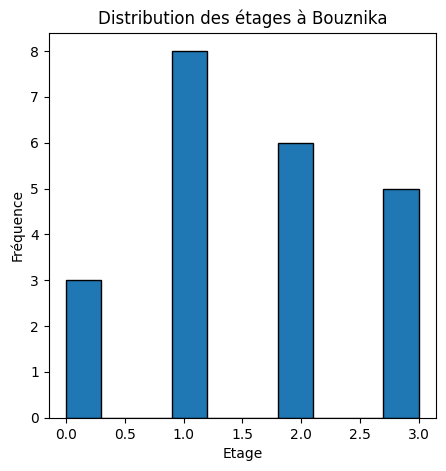

In [492]:
plt.figure(figsize=(5, 5))
plt.hist(fill_bouznika['Etage'].dropna(), bins=10, edgecolor='black')
plt.xlabel('Etage')
plt.ylabel('Fréquence')
plt.title('Distribution des étages à Bouznika')
plt.show()

In [493]:
data['Etage']=np.where(
    (data['Localisation']=='bouznika') & (data['Etage'].isna()) ,
    fill_bouznika['Etage'].mode() , data['Etage']
)

In [494]:
##Pour la ville el jadida
fill_jadida = data[data['Localisation']=='el jadida']
df_jadida = fill_jadida[fill_jadida['Secteur']=='quartier aérodrome']
data['Etage'] = np.where(
    (data['Localisation']=='el jadida') & (data['Etage'].isna()) ,   ###title : appartement rez de chaussée a vendre
    '0' , data['Etage']
)

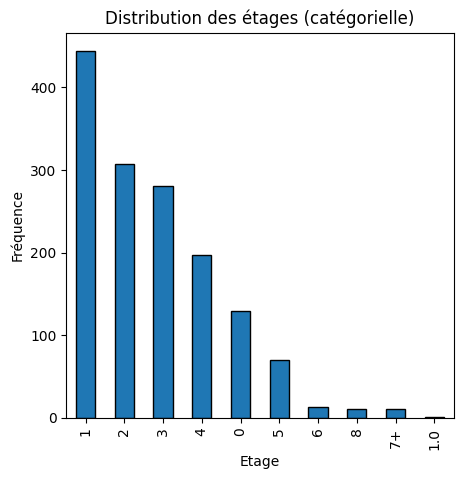

In [495]:
### pour la ville fquih ben saleh	
etage_values = data['Etage'].dropna()

# Créer l'histogramme avec des catégories
plt.figure(figsize=(5, 5))
etage_values.value_counts().plot(kind='bar', edgecolor='black')  # Bar plot pour les catégories
plt.xlabel('Etage')
plt.ylabel('Fréquence')
plt.title('Distribution des étages (catégorielle)')
plt.xticks()
plt.show()

In [496]:
fil_fquih_ben_saleh=data[data['Localisation']=='fquih ben saleh']
fil_fquih_ben_saleh

data['Etage']=np.where(
    (data['Localisation']=='fquih ben saleh') & (data['Etage'].isna()) , 
    '1' , data['Etage']
)

In [497]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 0 to 1464
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   URL                1463 non-null   object 
 1   Title              1463 non-null   object 
 2   Localisation       1463 non-null   object 
 3   Price              1177 non-null   float64
 4   Chambre            1463 non-null   object 
 5   Salle de bain      1463 non-null   int64  
 6   Type               1463 non-null   object 
 7   Secteur            1463 non-null   object 
 8   Salons             1432 non-null   float64
 9   Surface habitable  1440 non-null   float64
 10  Age de bien        1183 non-null   float64
 11  Etage              1463 non-null   object 
 12  Frais de syndic    536 non-null    float64
 13  Ascenseur          1463 non-null   bool   
 14  Balcon             1463 non-null   bool   
 15  Chauffage          1463 non-null   bool   
 16  Climatisation      1463 non-n

In [498]:
###GERER LES VALEURS NAN POUR LES VARIABLE SALON  , SALLE DE BAIN  , SURFACE HABITABLE

#encode categorical columns

type_encoder = LabelEncoder()
secteur_encoder = LabelEncoder()
localisation_encoder = LabelEncoder()
chambre_encoder = LabelEncoder()

###APPLIQUER label encoding
data['Type'] = type_encoder.fit_transform(data['Type'])
data['Secteur'] = secteur_encoder.fit_transform(data['Secteur'])
data['Localisation'] = localisation_encoder.fit_transform(data['Localisation'])
data['Chambre'] = chambre_encoder.fit_transform(data['Chambre'])

###INITAILISER KNNIMPUTER
imputer = KNNImputer(n_neighbors=3)

In [499]:
### Appliquer KNNIMPUTATION POUR COLONNE SALON
df_salon = data[data['Salons'].isna()]

loca_salons = df_salon['Localisation'].value_counts().reset_index()
loca_salons.columns = ['Localisation', 'Count']

for locality in loca_salons['Localisation']:
    data_loca = data[data['Localisation'] == locality]
    
    columns_to_impute = ['Chambre', 'Salle de bain', 'Type', 'Secteur']
    
    imputed_values = imputer.fit_transform(data_loca[columns_to_impute])
    
    data.loc[data['Localisation'] == locality, 'Salons'] = imputed_values[:, 0]



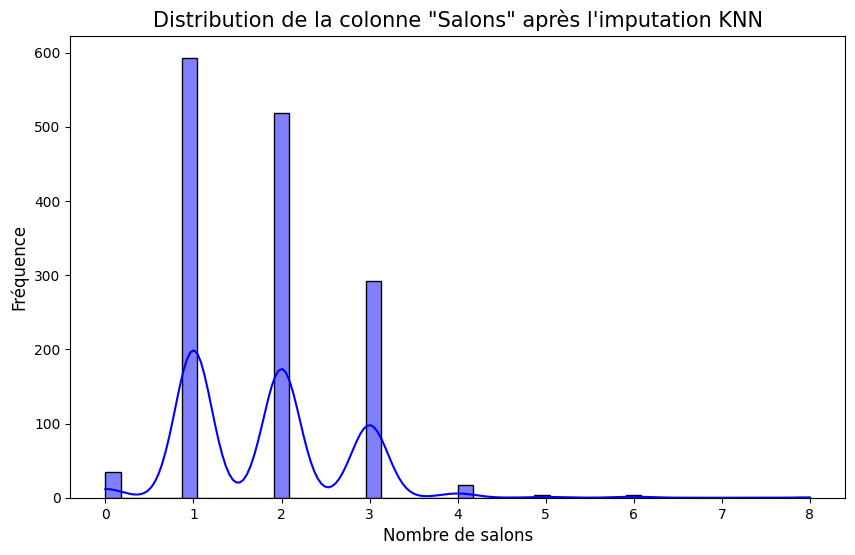

In [500]:
###Distribution de la colonne Salon apres KNN
plt.figure(figsize=(10, 6))

# Histogramme
sns.histplot(data['Salons'], kde=True, color='blue')
plt.title('Distribution de la colonne "Salons" après l\'imputation KNN', fontsize=15)
plt.xlabel('Nombre de salons', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.show()

In [501]:
###Appliquer le KNNIMPUTATION pour la colonne surface habitable 
df_age = data[data['Surface habitable'].isna()]

loca_age = df_age['Localisation'].value_counts().reset_index()
loca_age.columns = ['Localisation', 'Count']

for locality in loca_age['Localisation']:
    data_loca = data[data['Localisation'] == locality]
    
    columns_to_impute = ['Chambre', 'Salle de bain', 'Type', 'Secteur', 'Salons']
    
    imputed_values = imputer.fit_transform(data_loca[columns_to_impute])
    
    data.loc[data['Localisation'] == locality, 'Surface habitable'] = imputed_values[:, 0]

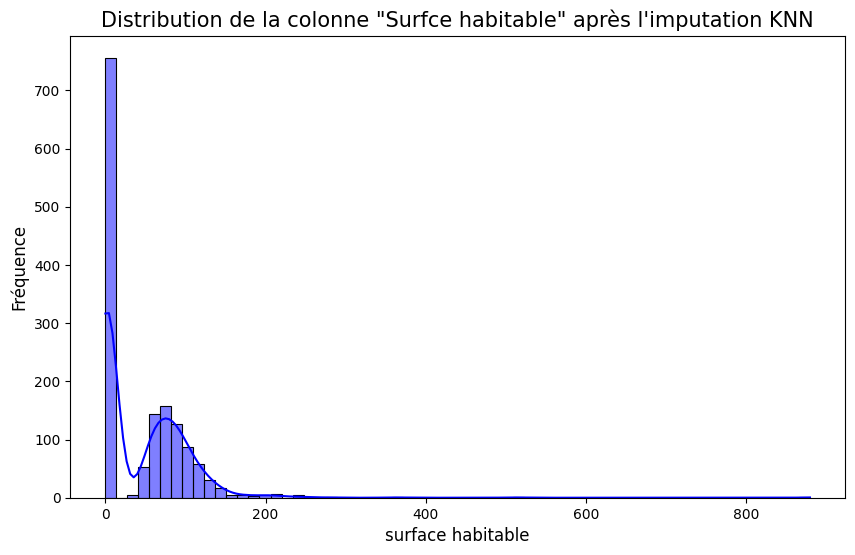

In [502]:
###Distribution de la colonne Surface habitable apres KNN
plt.figure(figsize=(10, 6))

# Histogramme
sns.histplot(data['Surface habitable'], kde=True, color='blue')
plt.title('Distribution de la colonne "Surfce habitable" après l\'imputation KNN', fontsize=15)
plt.xlabel('surface habitable', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.show()

In [503]:
###Appliquer le KNNIMPUTATION pour la colonne age de bien
df_age = data[data['Age de bien'].isna()]

loca_age = df_age['Localisation'].value_counts().reset_index()
loca_age.columns = ['Localisation', 'Count']

for locality in loca_age['Localisation']:
    # Filter data by the current locality
    data_loca = data[data['Localisation'] == locality]
    
    # Select features for imputation (excluding 'Âge du bien' itself)
    columns_to_impute = ['Chambre', 'Salle de bain', 'Type', 'Secteur', 'Salons']
    
    # Apply KNN imputation for the 'Âge du bien' column only
    imputed_values = imputer.fit_transform(data_loca[columns_to_impute])
    
    # Update the 'Âge du bien' column in the original data with imputed values
    data.loc[data['Localisation'] == locality, 'Age de bien'] = imputed_values[:, 0]
 


C:\Users\Youcode\AppData\Local\Temp\ipykernel_17020\2990333428.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Age de bien', data=data, palette='Blues_d')


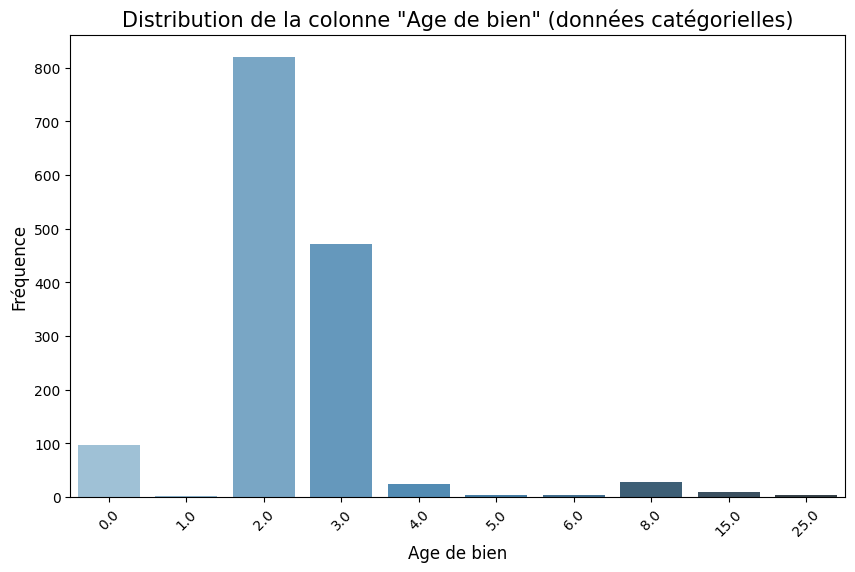

In [504]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Age de bien', data=data, palette='Blues_d')

# Ajouter un titre et des labels
plt.title('Distribution de la colonne "Age de bien" (données catégorielles)', fontsize=15)
plt.xlabel('Age de bien', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.xticks(rotation=45)  # Rotation des labels de l'axe x pour une meilleure lisibilité
plt.show()

count       536.000000
mean       8052.272388
std       75242.521657
min           1.000000
25%         100.000000
50%         150.000000
75%         250.000000
max      950000.000000
Name: Frais de syndic, dtype: float64
--------------------------------------------------------------
Le pourcentagge des donnees nul est  0.6336295283663704
--------------------------------------------------------------


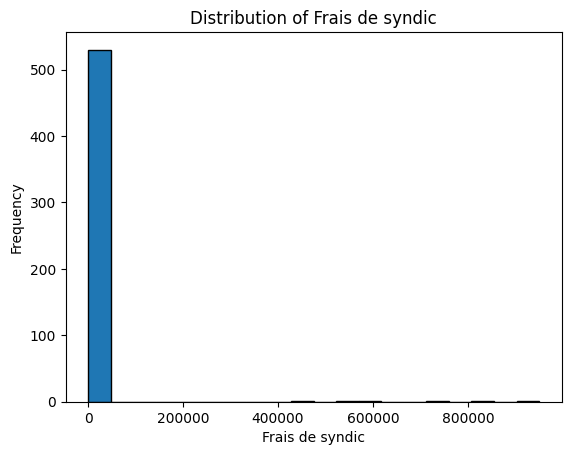

In [505]:
#### Gerer LES VALEURS NAN de frais de syndic
# Summary statistics
print(data['Frais de syndic'].describe())
null_frais_sundayc=len(data[data['Frais de syndic'].isna()])/len(data['Frais de syndic'])
print('--------------------------------------------------------------')
print('Le pourcentagge des donnees nul est ' , null_frais_sundayc)
print('--------------------------------------------------------------')
# Visualize the distribution
import matplotlib.pyplot as plt
plt.hist(data['Frais de syndic'].dropna(), bins=20, edgecolor='black')
plt.xlabel('Frais de syndic')
plt.ylabel('Frequency')
plt.title('Distribution of Frais de syndic')
plt.show()


In [506]:
data=data.drop('Frais de syndic' , axis=1)

In [507]:
data[data['Chambre'].isna()]


,URL,Title,Localisation,Price,Chambre,Salle de bain,Type,Secteur,Salons,Surface habitable,Age de bien,Etage,Ascenseur,Balcon,Chauffage,Climatisation,Concierge,Cuisine equipee,Duplex,Meuble,Parking,Securite,Terrasse


In [508]:
'''##Pour assilah
chambre_nan=data[data['Localisation']=='asilah']
mode_chambre=chambre_nan['Chambre'].mode()

data['Chambre'] = np.where(
   (data['Localisation']=='asilah') & (data['Chambre'].isna()) , 
   mode_chambre , data['Chambre']
)'''

"##Pour assilah\nchambre_nan=data[data['Localisation']=='asilah']\nmode_chambre=chambre_nan['Chambre'].mode()\n\ndata['Chambre'] = np.where(\n   (data['Localisation']=='asilah') & (data['Chambre'].isna()) , \n   mode_chambre , data['Chambre']\n)"

In [509]:
'''###Pour casablanca
Chambre_nan_casa = data[data['Localisation']=='casablanca']
ch=Chambre_nan_casa[Chambre_nan_casa['Secteur']=='sidi bernoussi']
mode_casa=ch['Chambre'].mode()

data['Chambre'] = np.where(
    (data['Localisation']=='casablanca') & (data['Chambre'].isna()) ,
    mode_casa , data['Chambre']
)'''

"###Pour casablanca\nChambre_nan_casa = data[data['Localisation']=='casablanca']\nch=Chambre_nan_casa[Chambre_nan_casa['Secteur']=='sidi bernoussi']\nmode_casa=ch['Chambre'].mode()\n\ndata['Chambre'] = np.where(\n    (data['Localisation']=='casablanca') & (data['Chambre'].isna()) ,\n    mode_casa , data['Chambre']\n)"

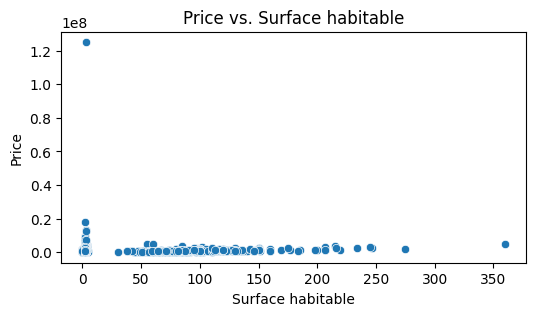

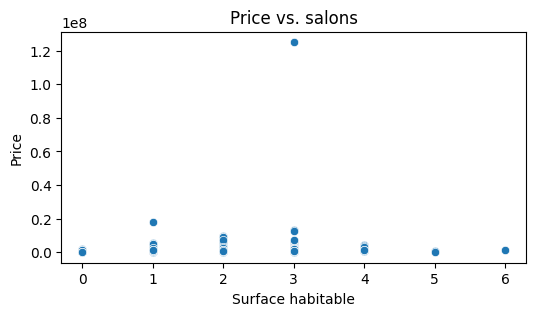

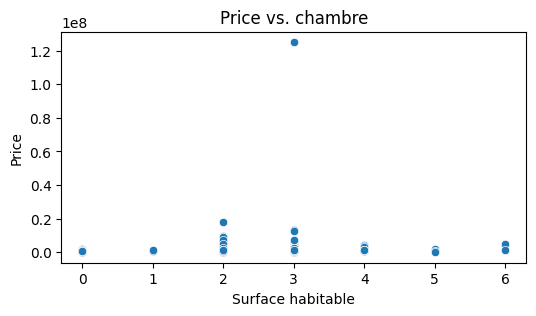

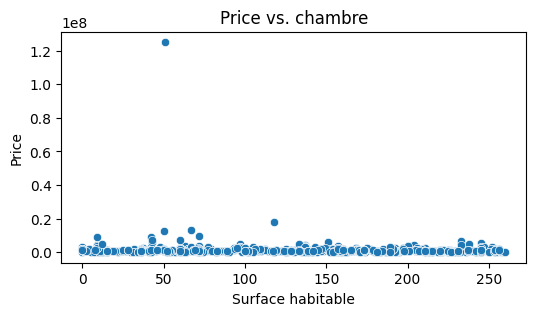

In [510]:
#### GERER LES VALEURS nan pour les prix 
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot to see potential nonlinear relationships
plt.figure(figsize=(6, 3))
sns.scatterplot(data=data, x='Surface habitable', y='Price')
plt.title("Price vs. Surface habitable")
plt.xlabel("Surface habitable")
plt.ylabel("Price")

plt.figure(figsize=(6, 3))
sns.scatterplot(data=data, x='Salons', y='Price')
plt.title("Price vs. salons")
plt.xlabel("Surface habitable")
plt.ylabel("Price")

plt.figure(figsize=(6, 3))
sns.scatterplot(data=data, x='Chambre', y='Price')
plt.title("Price vs. chambre")
plt.xlabel("Surface habitable")
plt.ylabel("Price")
plt.show()

plt.figure(figsize=(6, 3))
sns.scatterplot(data=data, x='Secteur', y='Price')
plt.title("Price vs. chambre")
plt.xlabel("Surface habitable")
plt.ylabel("Price")
plt.show()
plt.show()


In [511]:
# 1. Separate rows with and without missing 'Price' values
data_with_price = data.dropna(subset=['Price'])
data_without_price = data[data['Price'].isna()]

# 2. Select predictive features
features = ['Chambre', 'Salle de bain', 'Surface habitable', 'Secteur']  # Adjust as needed
X_train = data_with_price[features]
y_train = data_with_price['Price']

# Make sure to handle any categorical features (e.g., 'Secteur') if they exist
X_train = pd.get_dummies(X_train, drop_first=True)
X_pred = pd.get_dummies(data_without_price[features], drop_first=True)

# Align columns in case some categories are missing in the test set
X_pred = X_pred.reindex(columns=X_train.columns, fill_value=0)

# 3. Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Predict missing 'Price' values
predicted_prices = model.predict(X_pred)

# 5. Assign the predicted prices to the missing values in the original DataFrame
data.loc[data['Price'].isna(), 'Price'] = predicted_prices

In [512]:
data['Type'] = type_encoder.inverse_transform(data['Type'])
data['Secteur'] = secteur_encoder.inverse_transform(data['Secteur'])
data['Localisation'] = localisation_encoder.inverse_transform(data['Localisation'])
data['Chambre'] = chambre_encoder.inverse_transform(data['Chambre'])

In [513]:
data.to_csv('cleaning_data6.csv' , index=False)

In [514]:
iso_forest = IsolationForest(contamination=0.05)

anomaly_scores = iso_forest.fit_predict(data[['Price']])

anomaly_counts = pd.Series(anomaly_scores).value_counts().reset_index()
anomaly_counts.columns = ['anomaly_score', 'count']

# Afficher les résultats
anomaly_counts

### si vous voulez afficher les donnees aberantes decommente les lignes
##anomalies_df = data[anomaly_scores == -1]
##anomalies_df


,anomaly_score,count
0,1,1390
1,-1,73


In [515]:
iso_forest = IsolationForest(contamination=0.05)

anomaly_scores = iso_forest.fit_predict(data[['Salons']])

anomaly_counts = pd.Series(anomaly_scores).value_counts().reset_index()
anomaly_counts.columns = ['anomaly_score', 'count']

# Afficher les résultats
anomaly_counts

### si vous voulez afficher les donnees aberantes decommente les lignes
##anomalies_df = data[anomaly_scores == -1]
##anomalies_df


,anomaly_score,count
0,1,1403
1,-1,60


In [516]:
# Convertir toutes les valeurs en chaînes de caractères pour assurer l'uniformité des types
data['Etage'] = data['Etage'].astype(str)

etage_encoding = LabelEncoder()
data['Etage'] = etage_encoding.fit_transform(data['Etage'])

# Initialisation et application d'Isolation Forest
iso_forest = IsolationForest(contamination=0.05)
anomaly_scores = iso_forest.fit_predict(data[['Etage']])

anomaly_counts = pd.Series(anomaly_scores).value_counts().reset_index()
anomaly_counts.columns = ['anomaly_score', 'count']

# Afficher les résultats
anomaly_counts

### si vous voulez afficher les donnees aberantes decommente les lignes
##anomalies_df = data[anomaly_scores == -1]
##anomalies_df

,anomaly_score,count
0,1,1429
1,-1,34


In [517]:
iso_forest = IsolationForest(contamination=0.05)

anomaly_scores = iso_forest.fit_predict(data[['Surface habitable']])

anomaly_counts = pd.Series(anomaly_scores).value_counts().reset_index()
anomaly_counts.columns = ['anomaly_score', 'count']

anomaly_counts

### si vous voulez afficher les donnees aberantes decommente les lignes
##anomalies_df = data[anomaly_scores == -1]
#anomalies_df


,anomaly_score,count
0,1,1395
1,-1,68


In [518]:
data[data['Age de bien'].isna()]

,URL,Title,Localisation,Price,Chambre,Salle de bain,Type,Secteur,Salons,Surface habitable,Age de bien,Etage,Ascenseur,Balcon,Chauffage,Climatisation,Concierge,Cuisine equipee,Duplex,Meuble,Parking,Securite,Terrasse


In [519]:
### Pour age de bien
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter

# Supposons que vous ayez des données déséquilibrées
# Sélection des caractéristiques (toutes les colonnes sauf 'Age de bien')
X = data[['Price']]  # Exemples de colonnes

# Variable cible : 'Age de bien'
y = data['Age de bien']  # Variable cible
print(y.unique())


# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Compter les occurrences de chaque classe avant SMOTE
print("Répartition des classes avant SMOTE :", Counter(y_train))

# Appliquer SMOTE
smote = SMOTE( k_neighbors=1, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Compter les occurrences de chaque classe après SMOTE
print("Répartition des classes après SMOTE :", Counter(y_train_smote))


[ 0.  3.  2.  4.  8.  1. 15. 25.  6.  5.]
Répartition des classes avant SMOTE : Counter({2.0: 569, 3.0: 337, 0.0: 67, 8.0: 19, 4.0: 17, 15.0: 6, 6.0: 3, 25.0: 2, 1.0: 2, 5.0: 2})
Répartition des classes après SMOTE : Counter({3.0: 569, 0.0: 569, 2.0: 569, 4.0: 569, 8.0: 569, 25.0: 569, 1.0: 569, 15.0: 569, 5.0: 569, 6.0: 569})


In [520]:
y_train_smote### Pour age de bien
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter

# Supposons que vous ayez des données déséquilibrées
# Sélection des caractéristiques (toutes les colonnes sauf 'Age de bien')
X = data[['Price']]  # Exemples de colonnes

# Variable cible : 'Age de bien'
y = data['Salons']  # Variable cible
print(y.unique())


# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Compter les occurrences de chaque classe avant SMOTE
print("Répartition des classes avant SMOTE :", Counter(y_train))

# Appliquer SMOTE
smote = SMOTE( k_neighbors=1, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Compter les occurrences de chaque classe après SMOTE
print("Répartition des classes après SMOTE :", Counter(y_train_smote))


[0. 3. 1. 2. 4. 5. 6. 8.]
Répartition des classes avant SMOTE : Counter({1.0: 417, 2.0: 361, 3.0: 206, 0.0: 24, 4.0: 11, 6.0: 3, 5.0: 2})
Répartition des classes après SMOTE : Counter({2.0: 417, 3.0: 417, 1.0: 417, 0.0: 417, 6.0: 417, 4.0: 417, 5.0: 417})


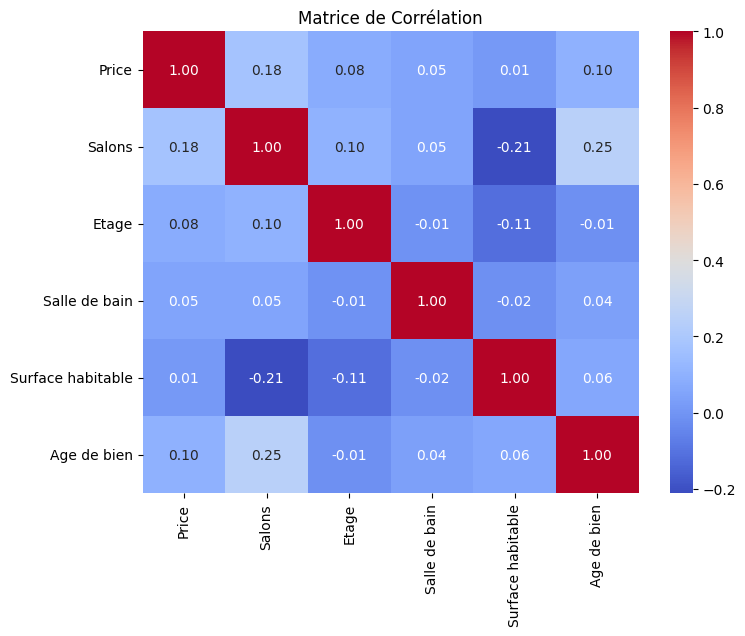

In [522]:
data_corr = data.copy()  # Créer une copie du DataFrame pour ne pas modifier l'original
data_corr = data[['Price' , 'Salons' ,'Etage'  , 'Salle de bain' , 'Surface habitable' , 'Age de bien']]  # Supprimer la colonne 'URL'

correlation_matrix = data_corr.corr()


# Visualisation avec un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de Corrélation')
plt.show()
